In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
### 前処理 ###
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [11]:
# データの確認

print(f'データ数：{len(train)}')
print(train.head())
print('データ型:')
print(train.dtypes)
print('===========================================================')
print(f'データ数：{len(test)}')
print(test.head())

データ数：2101
    datetime   y  client  close  price_am  price_pm
0 2010-07-01  17       0      0        -1        -1
1 2010-07-02  18       0      0        -1        -1
2 2010-07-03  20       0      0        -1        -1
3 2010-07-04  20       0      0        -1        -1
4 2010-07-05  14       0      0        -1        -1
データ型:
datetime    datetime64[ns]
y                    int64
client               int64
close                int64
price_am             int64
price_pm             int64
dtype: object
データ数：365
    datetime  client  close  price_am  price_pm
0 2016-04-01       1      0         3         2
1 2016-04-02       0      0         5         5
2 2016-04-03       1      0         2         2
3 2016-04-04       1      0         1         1
4 2016-04-05       0      0         1         1


Text(0, 0.5, 'value')

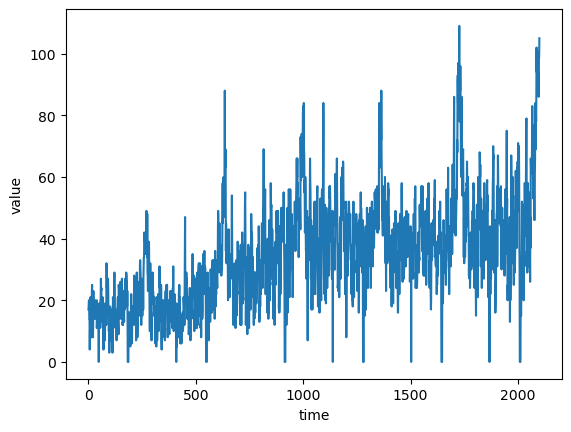

In [13]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.set_xlabel('time')
ax.set_ylabel('value')

In [16]:
### 統計解析（時系列分析）による予測
### →日次データのため不向き
### →月次データに修正して予測すべき？？？

In [18]:
decomposition = STL(train.y, period=365).fit()

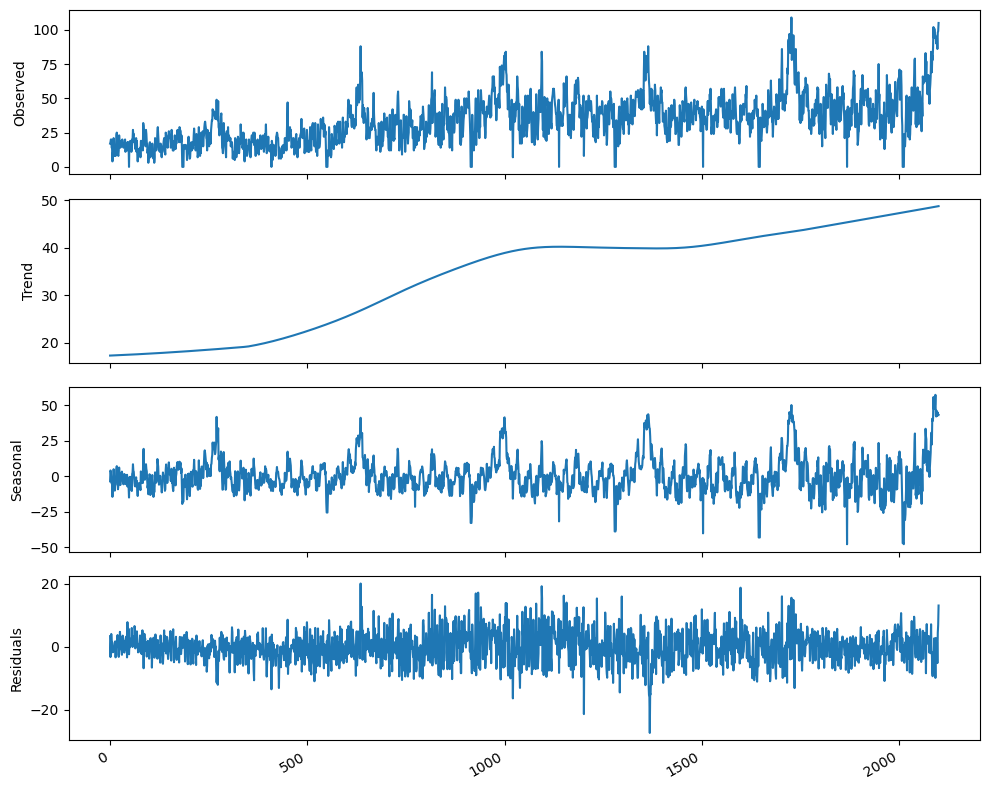

In [19]:
# trainデータを’トレンド’、’季節’、’残差’に分解して可視化

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()

In [21]:
# 時系列が定常か判定（ADF検定）

ad_fuller_result = adfuller(train.y)
print(f'ADF統計量：{ad_fuller_result[0]}')
print(f'p-値：{ad_fuller_result[1]}')

ADF統計量：-1.4156382004506156
p-値：0.574756432591291


In [24]:
# 定常でないため階差をとる

y_diff = np.diff(train.y, n=1)
ad_fuller_result2 = adfuller(y_diff)
print(f'ADF統計量：{ad_fuller_result2[0]}')
print(f'p-値：{ad_fuller_result2[1]}')

ADF統計量：-15.911584423633695
p-値：8.112058795132015e-29


In [29]:
####################################
### 月次データに変換して再度、時系列分析 ###
####################################

### SARIMAモデルによる予測 ###

train_ = train.set_index('datetime', inplace=False)
train_monthly = train_[['y']].resample('M').sum()

In [31]:
# 月次データになったことを確認

train_monthly

,y
datetime,
2010-07-31,480
2010-08-31,512
2010-09-30,494
2010-10-31,425
2010-11-30,493
...,...
2015-11-30,1102
2015-12-31,1418
2016-01-31,1119


In [33]:
print(len(train))
print(len(train_monthly))

2101
69


Text(0, 0.5, 'value')

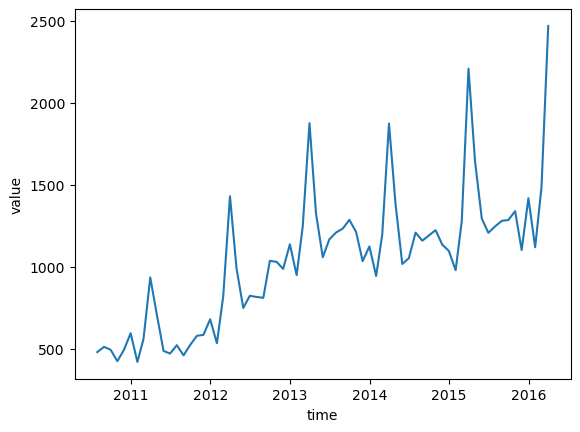

In [35]:
fig, ax = plt.subplots()

ax.plot(train_monthly['y'])
ax.set_xlabel('time')
ax.set_ylabel('value')

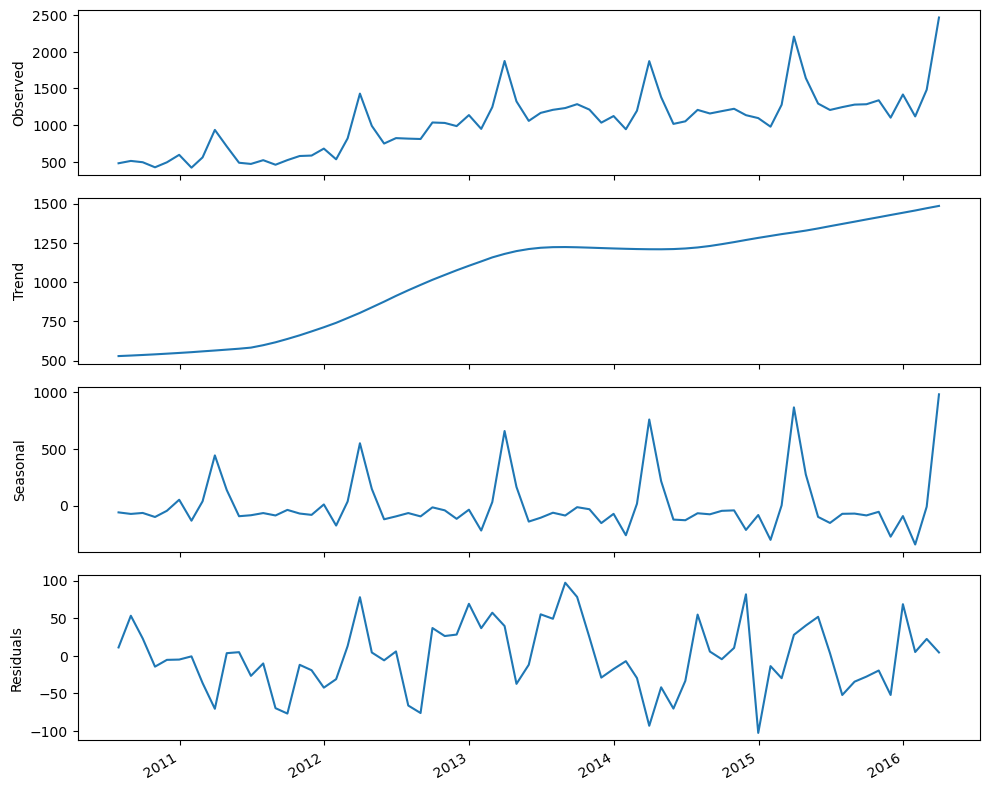

In [37]:
# trainデータを’トレンド’、’季節’、’残差’に分解して可視化

decomposition = STL(train_monthly.y, period=12).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()

In [38]:
# 時系列が定常か判定（ADF検定）

ad_fuller_result_m = adfuller(train_monthly.y)
print(f'ADF統計量：{ad_fuller_result_m[0]}')
print(f'p-値：{ad_fuller_result_m[1]}')

ADF統計量：-1.4161671633843615
p-値：0.5745013063083005


In [41]:
# 定常でないため階差をとる

y_m_diff = np.diff(train_monthly.y, n=1)

ad_fuller_result_m_1 = adfuller(y_m_diff)
print(f'ADF統計量：{ad_fuller_result_m_1[0]}')
print(f'p-値：{ad_fuller_result_m_1[1]}')

ADF統計量：-1.9748687407233527
p-値：0.29769980873839563


In [43]:
# さらに階差をとる 
#季節周期が考えられるため, n=12とする

y_m_diff_seasonal = np.diff(y_m_diff, n=12)

ad_fuller_result_m_s = adfuller(y_m_diff_seasonal)
print(f'ADF統計量：{ad_fuller_result_m_s[0]}')
print(f'p-値：{ad_fuller_result_m_s[1]}')

ADF統計量：-6.93701944670864
p-値：1.0482864684541757e-09


In [83]:
# SARIMA(p, d, q)(P, D, Q)_s, d=D=1, s=12が決定
# 以下、パラメータ　p, q, P, Q　として候補の中からAIC(赤池情報量基準)の小さいものを選ぶ

train_s = train_monthly.y[:-12]
test_s = train_monthly.y[-12:]

print(len(train_s))
print(len(test_s))

57
12


In [47]:
from tqdm.notebook import tqdm

In [49]:
### AICからパラメータを特定する関数（書籍から引用）

def optim_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [51]:
# パラメータの範囲を指定（計算に時間がかかるため各0~2までで指定）

ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

In [53]:
sarima_result = optim_SARIMAX(train_s, None, order_list, d, D, s)
sarima_result

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 0, 0, 0)",531.480442
1,"(0, 0, 2, 1)",531.787729
2,"(2, 2, 0, 0)",531.791882
3,"(0, 0, 2, 2)",531.877866
4,"(0, 0, 0, 2)",532.147130
...,...,...
76,"(2, 1, 2, 0)",537.073376
77,"(1, 2, 2, 0)",537.217683
78,"(1, 2, 1, 1)",538.299028
79,"(2, 2, 1, 2)",538.846272


In [293]:
# 一番AICが小さいのは(0, 0, 0, 0)だが、ほぼ同じAICの(2, 2, 0, 0)でモデル化を試みる

sarima_model = SARIMAX(train_s, order=(2, 1, 2), seasonal_order=(0, 1, 0, 12),
                       simple_differencing=False)

sarima_model_fit = sarima_model.fit(disp=False)

print(sarima_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   57
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                -260.896
Date:                             Wed, 07 Aug 2024   AIC                            531.792
Time:                                     17:33:49   BIC                            540.713
Sample:                                 07-31-2010   HQIC                           535.100
                                      - 03-31-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2172      0.111    -10.994      0.000      -1.434      -1.000
ar.L2         -0.9251      

TypeError: 'Figure' object is not subscriptable

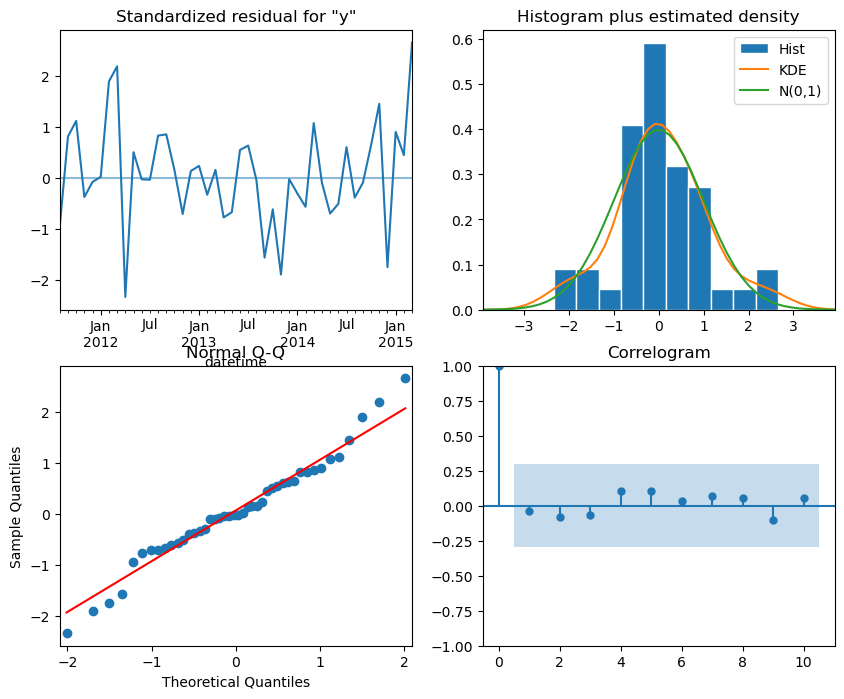

In [295]:
sarima_model_fit.plot_diagnostics(figsize=(10, 8))[0]

In [297]:
residuals = sarima_model_fit.resid

result = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result

,lb_stat,lb_pvalue
1,0.003866,0.950424
2,2.674642,0.262548
3,2.848662,0.415552
4,2.986580,0.560074
5,3.446831,0.631448
6,3.579686,0.733339
7,5.200944,0.635456
8,6.392215,0.603386
9,8.466490,0.487902
10,10.131295,0.429051


In [299]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,2), seasonal_order=(0,1,0,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [301]:
pred_df = train_monthly[-12:]

In [303]:
TRAIN_LEN = 57
HORIZON = 12
WINDOW = 12

pred_df['last_season'] = rolling_forecast(train_monthly, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,y,last_season
datetime,,
2015-04-30,1642,1382
2015-05-31,1294,1017
2015-06-30,1207,1052
2015-07-31,1246,1208
2015-08-31,1280,1159
2015-09-30,1285,1191
2015-10-31,1339,1223
2015-11-30,1102,1136
2015-12-31,1418,1096


In [305]:
pred_df['SARIMA'] = rolling_forecast(train_monthly, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,y,last_season,SARIMA
datetime,,,
2015-04-30,1642,1382,1731.147384
2015-05-31,1294,1017,1340.634349
2015-06-30,1207,1052,1393.600786
2015-07-31,1246,1208,1551.334028
2015-08-31,1280,1159,1483.603984
2015-09-30,1285,1191,1536.798384
2015-10-31,1339,1223,1560.327816
2015-11-30,1102,1136,1464.031497
2015-12-31,1418,1096,1443.182716


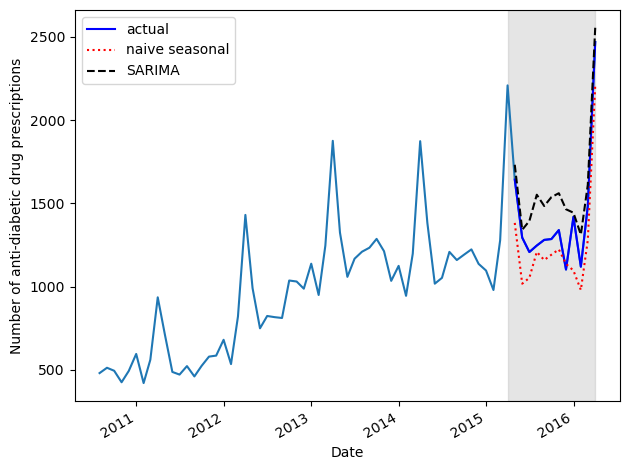

In [307]:
fig, ax = plt.subplots()

ax.plot(train_monthly.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

ax.axvspan('2015-04-01', '2016-03-31', color='#808080', alpha=0.2)
ax.legend(loc=2)





fig.autofmt_xdate()
plt.tight_layout()

In [309]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [311]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

11.768876985999874 13.746020073862761


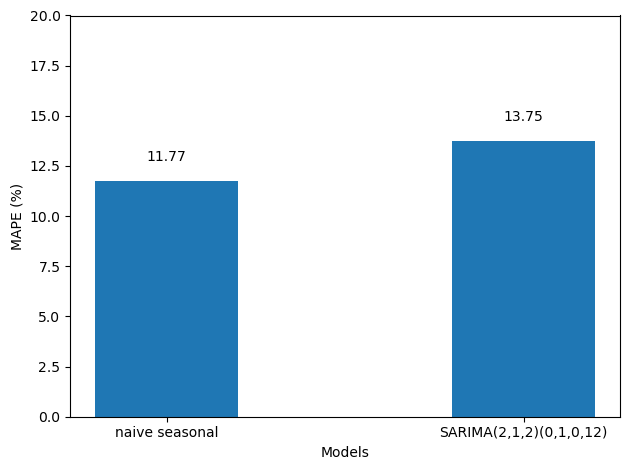

In [315]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,2)(0,1,0,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 20)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

In [ ]:
# SARIMAモデルを当てはめたが精度は良くなかった
# 月次変換したためデータ数が減ったことが原因？